<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/rf_0_25m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rasterio.windows import Window
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from tqdm import tqdm
import time
import warnings
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import morphology
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

Please paste the path to your zip file from the sidebar: /content/drive/MyDrive/scraghbog.zip
Successfully unzipped to /content/dataset
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")

Summer RGB Path: /content/dataset/scraghbog/scraghbog_rgb_summer.tif
Summer NDVI Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Summer DSM Path: /content/dataset/scraghbog/scraghbog_dem_summer.tif
Winter RGB Path: /content/dataset/scraghbog/Scraghbog_RGB_winter.tif
Winter NDVI Path: /content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif
Winter DSM Path: /content/dataset/scraghbog/Scraghbog_Winter_DSM.tif
Shapefile (.shp) Path: /content/dataset/scraghbog/scraghBog_habiMap.shp


In [4]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


KERNEL = 17
TARGET_RES = 0.25 # 0.25m Resolution

In [5]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen & flush',
    'PF3': 'bog',
    'WD4': 'Tree plantation',
    'WN6': 'willow',
    'WN7': 'bog woodland',
    'FS1': 'Swamp reeds',
    'FS2': 'Swamp',
    'FW2/WL2': 'water'
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)



In [6]:
def get_optimized_features(win_data, res):
    eps = 1e-7
    # 1-3. Summer RGB (Means)
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    # 4-6. Winter RGB (Means)
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')
    # 7-8. NDVI (Means)
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)

    def calc_vari(rgb):
        r, g, b = rgb[0], rgb[1], rgb[2]
        return (g - r) / (g + r - b + eps)

    s_vari = np.clip(calc_vari(s_rgb), -10, 10)
    w_vari = np.clip(calc_vari(w_rgb), -10, 10)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    def get_slope(dsm_data):
        dz_dy, dz_dx = np.gradient(dsm_data.astype('float64'), res)
        return np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))

    s_slope = get_slope(win_data['s_dsm'])
    w_slope = get_slope(win_data['w_dsm'])
    s_std = np.nanstd(win_data['s_rgb'][1])
    w_std = np.nanstd(win_data['w_rgb'][1])

    features = np.concatenate([
        s_rgb, w_rgb,          # 1-6
        [s_nd, w_nd],          # 7-8
        [s_vari, w_vari],      # 9-10
        [s_nd - w_nd],         # 11: Delta NDVI
        [s_h, w_h],            # 12-13: Heights
        [s_h - w_h],           # 14: Delta Height
        [s_slope, w_slope],    # 15-16: Slopes
        [s_std, w_std]         # 17-18: Texture
    ])
    return np.nan_to_num(features).astype('float32')

In [7]:
def resample_raster(path, target_res):
    with rasterio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, src.crs, src.width, src.height, *src.bounds, resolution=target_res)
        data = np.zeros((src.count, height, width), dtype='float32')
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i), destination=data[i-1],
                      src_transform=src.transform, src_crs=src.crs,
                      dst_transform=transform, dst_crs=src.crs, resampling=Resampling.bilinear)
        return data, transform

# 4. LOAD AND RESAMPLE
print(f"Resampling all layers to {TARGET_RES}m...")
s_rgb, master_xf = resample_raster(S_RGB_PATH, TARGET_RES)
s_nd, _  = resample_raster(S_NDVI_PATH, TARGET_RES)
s_dsm, _ = resample_raster(S_DSM, TARGET_RES)
w_rgb, _ = resample_raster(W_RGB_PATH, TARGET_RES)
w_nd, _  = resample_raster(W_NDVI_PATH, TARGET_RES)
w_dsm, _ = resample_raster(W_DSM, TARGET_RES)

Resampling all layers to 0.25m...


In [8]:
X_list, y_list = [], []
start_time = time.time()
for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Extracting Samples"):
    geom = row.geometry
    poly_win = rasterio.windows.from_bounds(*geom.bounds, transform=master_xf).round_offsets().round_shape()
    r_off, c_off = int(poly_win.row_off), int(poly_win.col_off)
    h, w = int(poly_win.height), int(poly_win.width)

    for r in range(0, h - KERNEL, KERNEL):
        for c in range(0, w - KERNEL, KERNEL):
            cx, cy = master_xf * (c_off + c + KERNEL//2, r_off + r + KERNEL//2)
            if Point(cx, cy).within(geom):
                win_data = {
                    's_rgb': s_rgb[:, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    's_ndvi': s_nd[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    's_dsm': s_dsm[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_rgb': w_rgb[:, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_ndvi': w_nd[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_dsm': w_dsm[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL]
                }
                if np.max(win_data['s_rgb']) > 0:
                    X_list.append(get_optimized_features(win_data, TARGET_RES))
                    y_list.append(row['merged_name'])

X, y = np.array(X_list), np.array(y_list)
print(f"\nExtraction complete: {len(X)} objects in {round((time.time()-start_time)/60, 2)}m")

Extracting Samples: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


Extraction complete: 14803 objects in 0.29m


In [9]:
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_samples=0.2,
                            class_weight='balanced', n_jobs=-1, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(rf, X, y, cv=kf)

print("\n--- 18-FEATURE CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred))
rf.fit(X, y)


--- 18-FEATURE CLASSIFICATION REPORT ---
                 precision    recall  f1-score   support

      Grassland       0.90      0.78      0.83       436
          Swamp       0.86      0.73      0.79      1502
    Swamp reeds       0.82      0.37      0.51       136
Tree plantation       0.97      0.94      0.95      1420
            bog       0.85      0.95      0.89      5415
   bog woodland       0.84      0.92      0.88      2998
    fen & flush       0.92      0.68      0.78       829
          water       0.28      0.25      0.26        53
         willow       0.84      0.72      0.78      2014

       accuracy                           0.86     14803
      macro avg       0.81      0.70      0.74     14803
   weighted avg       0.86      0.86      0.86     14803



RandomForestClassifier(class_weight='balanced', max_samples=0.2,
                       n_estimators=500, n_jobs=-1, random_state=42)

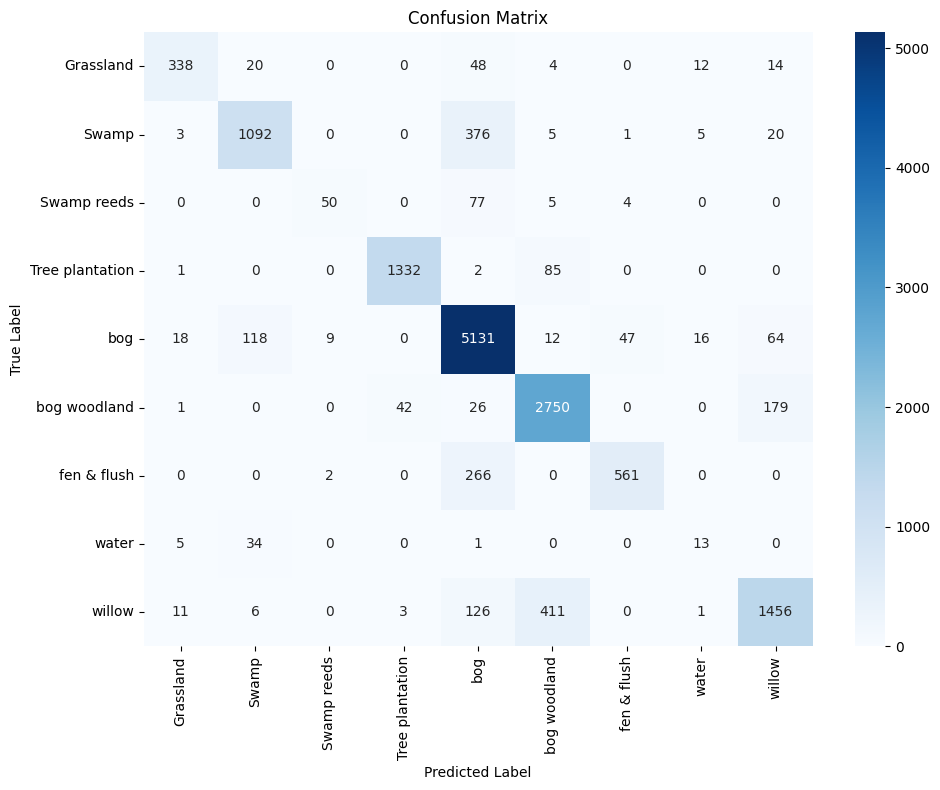

In [10]:
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [11]:
import joblib

# This saves it to the main folder of your Google Drive
# You can change 'My Drive/land_cover_model.pkl' to include a specific folder if you want
path = '/content/drive/My Drive/rf_model_0.25m_all classes.pkl'

joblib.dump(rf, path)

print(f"Success! Your model is now safely stored in your Google Drive at: {path}")

Success! Your model is now safely stored in your Google Drive at: /content/drive/My Drive/rf_model_0.25m_all classes.pkl


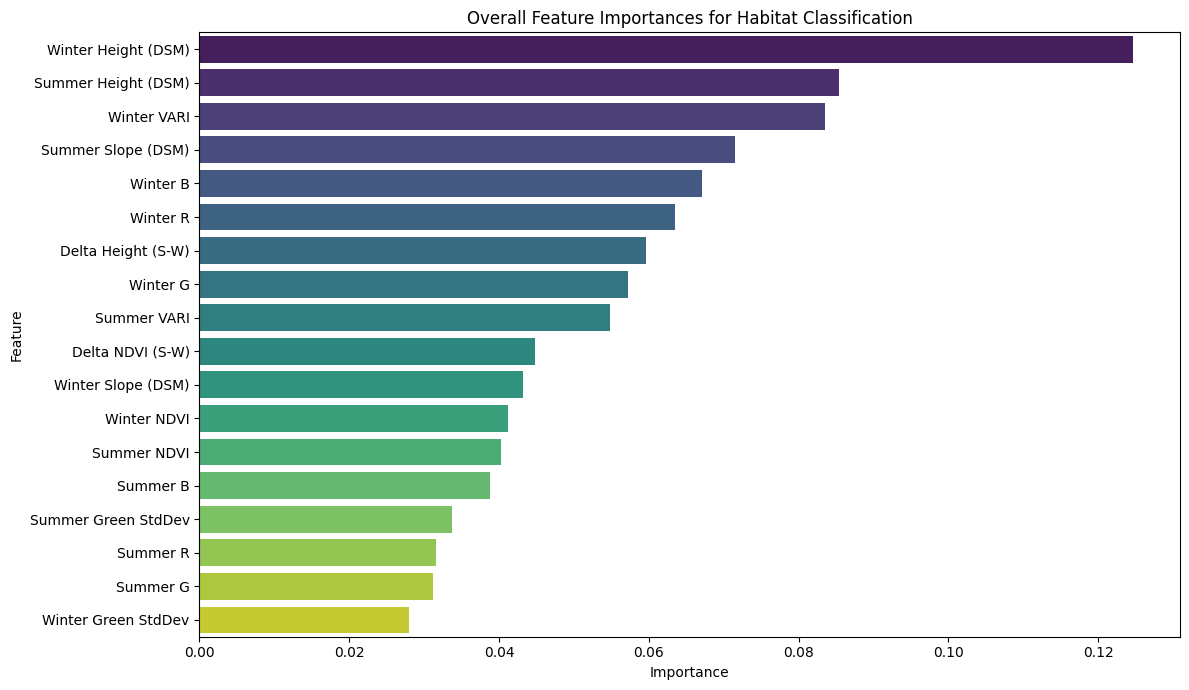


Top 10 Most Important Features:
            Feature  Importance
Winter Height (DSM)    0.124684
Summer Height (DSM)    0.085426
        Winter VARI    0.083478
 Summer Slope (DSM)    0.071444
           Winter B    0.067113
           Winter R    0.063465
 Delta Height (S-W)    0.059690
           Winter G    0.057241
        Summer VARI    0.054795
   Delta NDVI (S-W)    0.044813


In [12]:
import pandas as pd

feature_names = [
    'Summer R', 'Summer G', 'Summer B',
    'Winter R', 'Winter G', 'Winter B',
    'Summer NDVI',
    'Winter NDVI',
    'Summer VARI',
    'Winter VARI',
    'Delta NDVI (S-W)',
    'Summer Height (DSM)',
    'Winter Height (DSM)',
    'Delta Height (S-W)',
    'Summer Slope (DSM)',
    'Winter Slope (DSM)',
    'Summer Green StdDev',
    'Winter Green StdDev'
]

# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title('Overall Feature Importances for Habitat Classification')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importances_df.head(10).to_string(index=False))


Calculate and visualize the feature importances for each habitat class using a one-vs-rest Random Forest Classifier model.


Iterate through each unique habitat class. For each class, train a binary RandomForestClassifier (one-vs-rest) to distinguish it from all other classes. Extract and store the feature importances from each of these class-specific models.


In [14]:
from sklearn.preprocessing import LabelEncoder

# Define class_names. This part was missing or executed out of order.
le = LabelEncoder()
y_encoded = le.fit_transform(y) # Fit the encoder to get all unique class labels
class_names = le.classes_ # Extract the class names from the encoder

class_importances = {}

for current_class in class_names:
    print(f"Training binary classifier for: {current_class}")
    # Create a binary target array: True for current_class, False otherwise
    y_binary = (y == current_class)

    # Instantiate a new RandomForestClassifier for binary classification
    binary_rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_samples=0.2,
                                       class_weight='balanced', n_jobs=-1, random_state=42)

    # Fit the binary classifier
    binary_rf.fit(X, y_binary)

    # Extract and store feature importances
    class_importances[current_class] = binary_rf.feature_importances_

print("Class-specific feature importances calculated.")

Training binary classifier for: Grassland
Training binary classifier for: Swamp
Training binary classifier for: Swamp reeds
Training binary classifier for: Tree plantation
Training binary classifier for: bog
Training binary classifier for: bog woodland
Training binary classifier for: fen & flush
Training binary classifier for: water
Training binary classifier for: willow
Class-specific feature importances calculated.


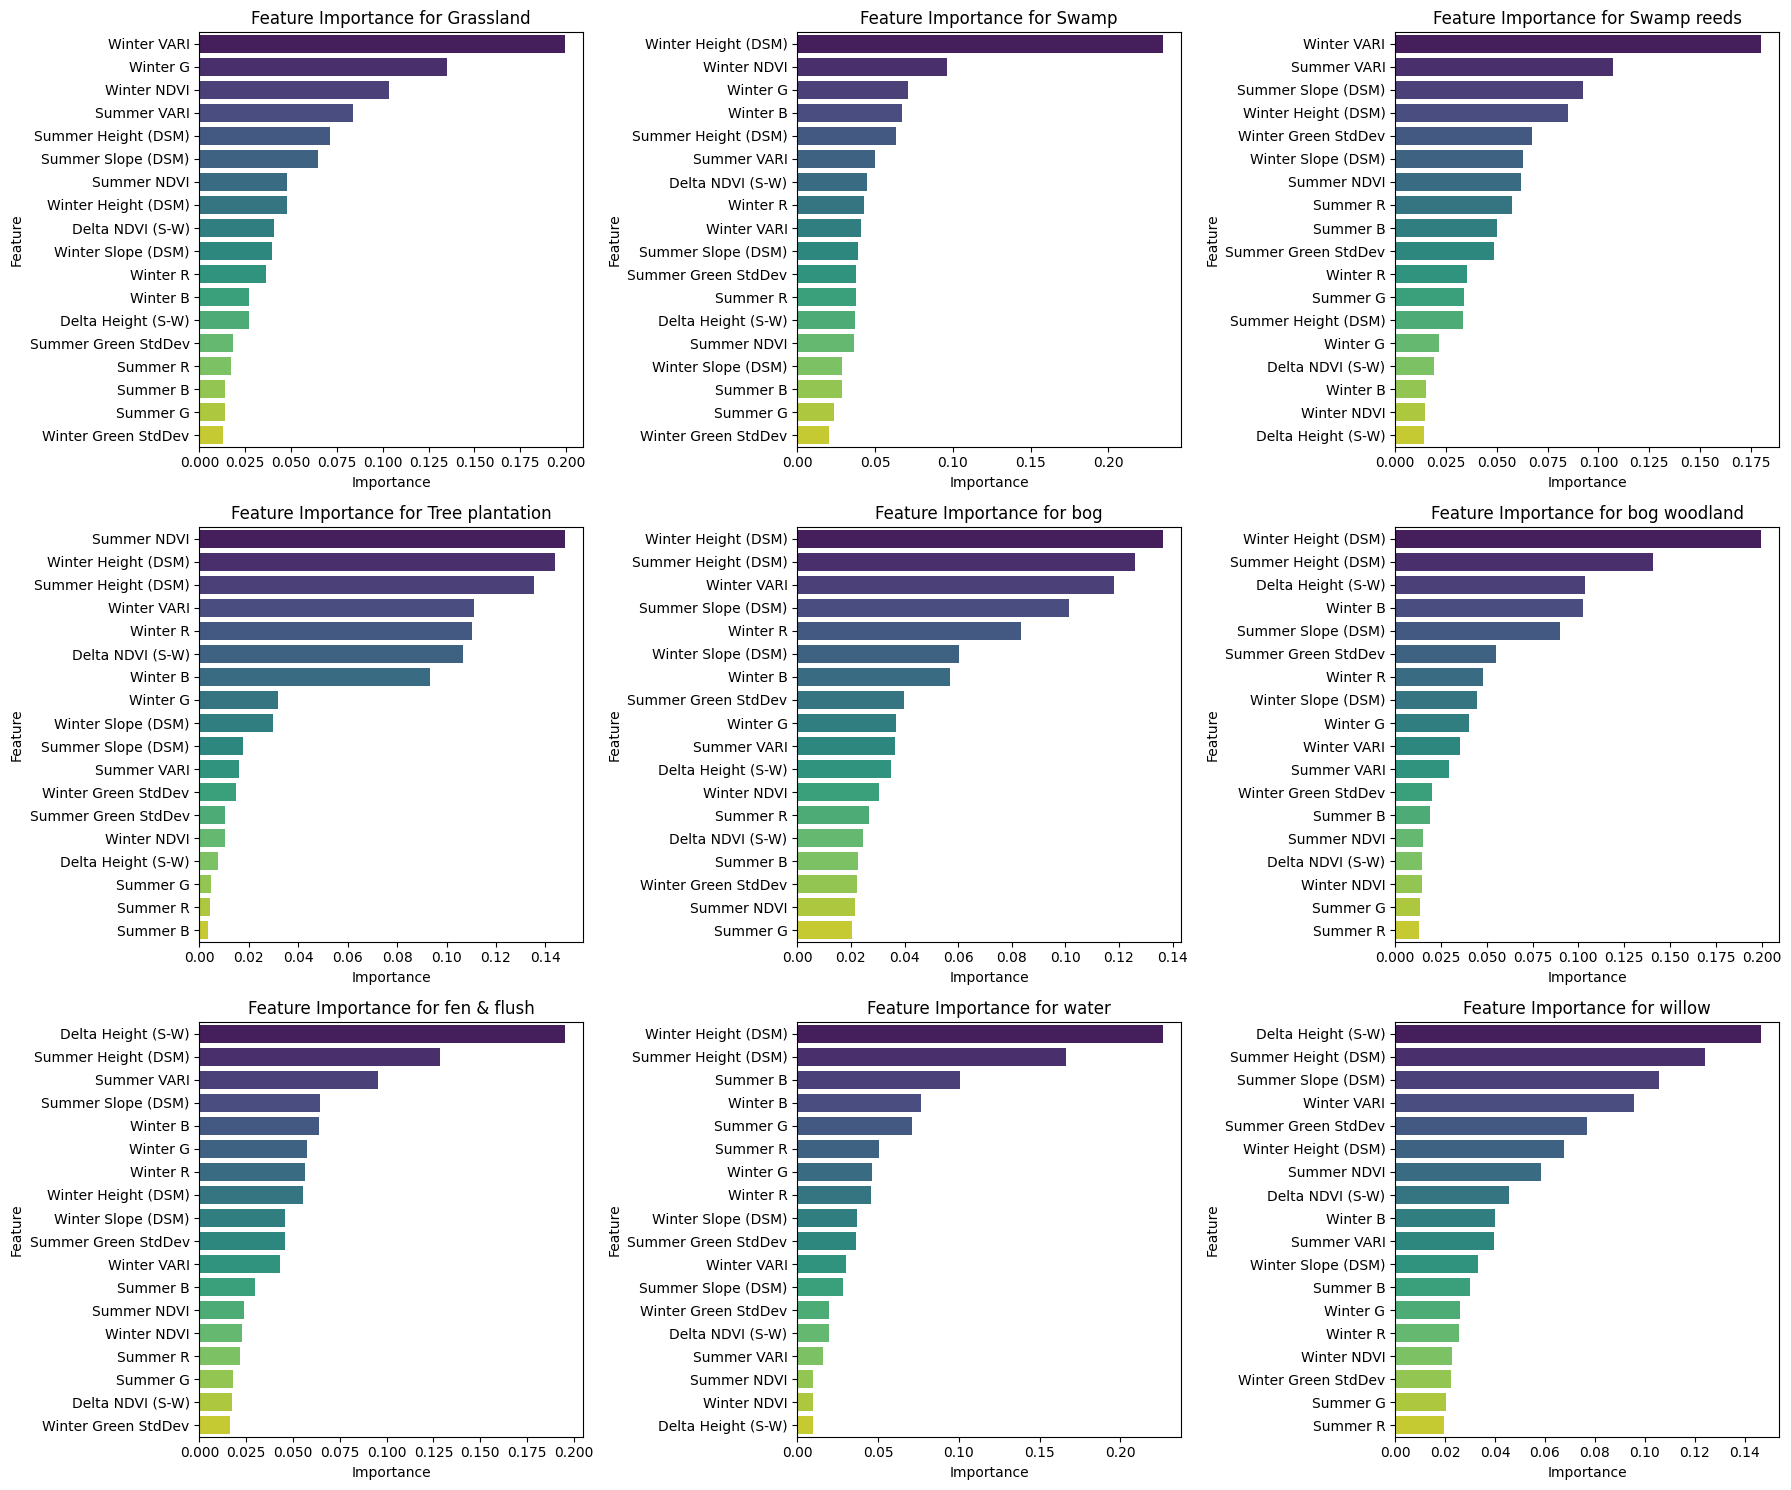

Class-specific feature importance plots displayed.


In [15]:
n_classes = len(class_names)
n_cols = 3 # Number of columns for subplots
n_rows = (n_classes + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), squeeze=False)
axes = axes.flatten()

for i, current_class in enumerate(class_names):
    ax = axes[i]

    # Create a DataFrame for better visualization
    class_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': class_importances[current_class]
    })

    # Sort by importance
    class_importances_df = class_importances_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances for the current class
    sns.barplot(x='Importance', y='Feature', data=class_importances_df, palette='viridis', ax=ax)
    ax.set_title(f'Feature Importance for {current_class}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
print("Class-specific feature importance plots displayed.")

In [16]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from rasterio.features import sieve

# 1. SYNC LABEL ENCODER
# This ensures we have all 9 classes: Grassland, Swamp, Bog, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Detected {len(class_names)} classes: {class_names}")

Detected 9 classes: ['Grassland' 'Swamp' 'Swamp reeds' 'Tree plantation' 'bog' 'bog woodland'
 'fen & flush' 'water' 'willow']


In [17]:
h, w = s_nd.shape[1], s_nd.shape[2]
prediction_map = np.full((h, w), -1, dtype='int16')

In [18]:
STEP = 20

print(f"Starting optimized classification...")
for r in tqdm(range(0, h - KERNEL, STEP)):
    for c in range(0, w - KERNEL, STEP):

        # Slicing is fast, but we only do it every 10 pixels now
        win_data = {
            's_rgb': s_rgb[:, r:r+KERNEL, c:c+KERNEL],
            's_ndvi': s_nd[0, r:r+KERNEL, c:c+KERNEL],
            's_dsm': s_dsm[0, r:r+KERNEL, c:c+KERNEL],
            'w_rgb': w_rgb[:, r:r+KERNEL, c:c+KERNEL],
            'w_ndvi': w_nd[0, r:r+KERNEL, c:c+KERNEL],
            'w_dsm': w_dsm[0, r:r+KERNEL, c:c+KERNEL]
        }

        if np.nanmax(win_data['s_rgb']) > 0:
            try:
                feat = get_optimized_features(win_data, TARGET_RES).reshape(1, -1)
                pred_label = rf.predict(feat)[0]
                idx = np.where(class_names == pred_label)[0][0]

                # Fill a larger block (10x10)
                prediction_map[r:r+STEP, c:c+STEP] = idx
            except:
                continue

Starting optimized classification...


100%|██████████| 234/234 [1:15:48<00:00, 19.44s/it]


In [19]:
prediction_map[prediction_map == -1] = 0

In [20]:
#4. ENFORCE 400m2 MMU (The Sieve)
print("\nEnforcing 400m2 Minimum Mapping Unit...")
# 400m2 / (0.5m * 0.5m) = 1600 pixels
pixel_limit = int(400 / (TARGET_RES**2))
final_map = sieve(prediction_map.astype('int16'), size=pixel_limit, connectivity=8)


Enforcing 400m2 Minimum Mapping Unit...


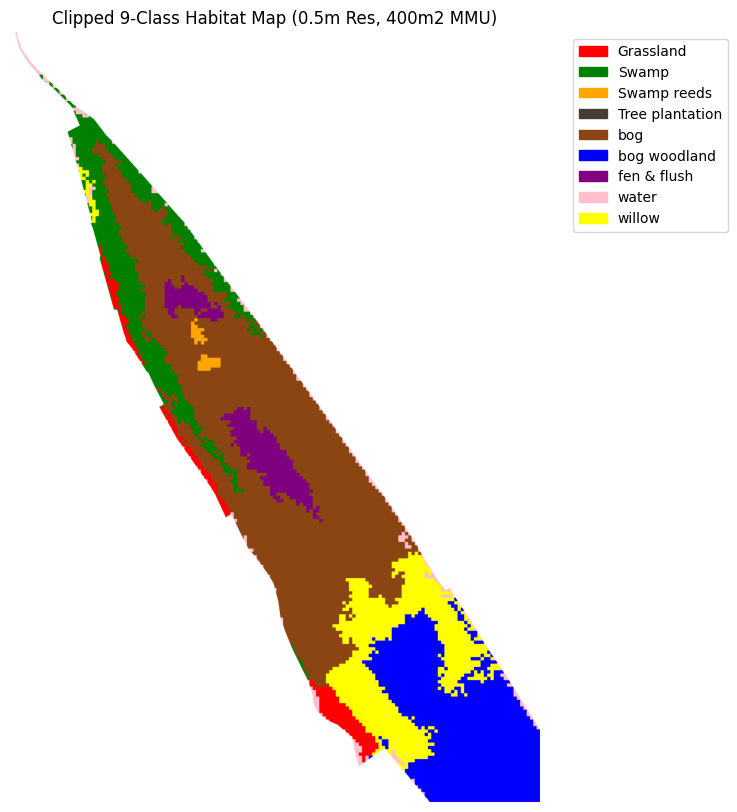

In [21]:
from rasterio import features
from rasterio.mask import mask

# 1. Create a binary mask from your shapefile
# This creates an array where 1 is inside your shapefile and 0 is outside
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = features.rasterize(
    shapes=shapes,
    out_shape=(h, w),
    transform=master_xf,
    fill=0,
    all_touched=True
)

# 2. Apply the mask to your final_map
# We set everything outside the shapefile (where mask_array == 0) to a background value
# Let's use -1 or a value that isn't one of your 9 classes
clipped_map = np.where(mask_array == 1, final_map, -1)

# 3. Visualization with Masking
plt.figure(figsize=(12, 10))

# Define colors for your 9 classes
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
# Add a 'white' or 'transparent' color for the clipped background (-1)
cmap_colors = ['#FFFFFF'] + colors
cmap = ListedColormap(cmap_colors)

# We shift the indices by 1 so that -1 becomes 0 (White)
plt.imshow(clipped_map + 1, cmap=cmap)

plt.title(f"Clipped 9-Class Habitat Map (0.5m Res, 400m2 MMU)")

# Create legend (only for actual classes, skipping the background)
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()